# <font color="cyan"/> Proteomics - Preprocessing and QC </font>

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from lifelines import KaplanMeierFitter
#from ydata_profiling import ProfileReport
import pickle
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter, KaplanMeierFitter, statistics

#from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import IterativeImputer
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.impute import KNNImputer

from lifelines import CoxPHFitter

%load_ext autoreload
%autoreload 2

from configs import IMMUNE_PROTEINS, PROCESSED_PROTEOMICS_DATA, KERATIN
from utils import load_raw_proteomics_data, rename_columns, drop_protein, describe_proteins_and_samples, norm_and_log,prepare_data_to_model
from survival_analysis_utils import cox_proportional_hazard_model


ModuleNotFoundError: No module named 'survival_analysis_utils'

In [11]:
df = load_raw_proteomics_data()
df_rename = rename_columns(df)
df_rename

Loading raw data: /home/labs/hornsteinlab/Collaboration/PRIMALS/Serum/inputs/processed_data/proteomics/report_DIANN_perseus_renamed.xlsx
Raw data shape: (2931, 737)
Processed data shape: (182, 2927)


,SERPINA1,IGKV3-7,IGLV4-69,IGLV8-61,IGLV4-60,IGLV10-54,IGLV5-48,IGLV7-46,IGLV5-37,IGLV2-18,...,DYNC1LI1,SQOR,ROBO1,AP1M2,FCGBP,PCLO,ENPP4,COLEC10,APOA2_1,C1QA_1
705,NaN,26.994150,19.456438,24.051470,NaN,NaN,NaN,23.794407,NaN,19.037565,...,NaN,NaN,18.556812,NaN,26.193142,24.404276,NaN,24.115852,17.400354,16.429993
712,22.788713,26.501820,20.506552,21.652561,NaN,15.526707,NaN,23.689150,19.139500,21.652479,...,NaN,NaN,NaN,NaN,26.399143,24.392073,14.644881,24.183258,20.512968,16.666363
717,23.193266,27.110550,20.337282,24.471611,NaN,17.641466,17.879177,24.169260,19.235241,20.474312,...,NaN,NaN,18.371347,NaN,26.458925,24.995104,14.890574,23.941626,20.411793,16.530718
735,22.373550,27.010569,20.202953,21.568390,NaN,15.806225,17.196611,23.633776,NaN,20.084829,...,NaN,NaN,19.056158,NaN,26.399658,23.731184,14.921144,24.030146,19.129568,18.274525
746,NaN,25.065210,16.824959,22.377676,NaN,NaN,NaN,21.762850,NaN,18.840582,...,NaN,NaN,NaN,NaN,26.111839,22.856924,NaN,24.066956,17.741055,18.024353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,24.449709,25.792524,19.875090,NaN,NaN,16.017612,NaN,24.103546,NaN,20.009727,...,NaN,14.58841,19.903526,NaN,26.323303,22.626335,NaN,24.012928,NaN,21.501604
1900,NaN,26.914776,19.079994,24.136343,NaN,NaN,NaN,23.200470,NaN,16.817045,...,NaN,NaN,NaN,NaN,25.727110,22.991014,NaN,23.927719,18.692131,22.086290
1912,25.052942,28.668724,21.214098,21.100986,NaN,16.926712,NaN,22.080864,NaN,19.550264,...,NaN,NaN,18.346825,NaN,26.735666,24.260542,NaN,23.880159,20.020214,20.131447
1913,23.401012,27.107197,20.525103,23.746323,NaN,NaN,NaN,23.933695,19.562668,20.330959,...,NaN,NaN,18.202869,NaN,26.974621,24.073875,NaN,24.201630,16.055094,19.486395


In [12]:
df_rename.describe()

,SERPINA1,IGKV3-7,IGLV4-69,IGLV8-61,IGLV4-60,IGLV10-54,IGLV5-48,IGLV7-46,IGLV5-37,IGLV2-18,...,DYNC1LI1,SQOR,ROBO1,AP1M2,FCGBP,PCLO,ENPP4,COLEC10,APOA2_1,C1QA_1
count,79.000000,182.000000,174.000000,175.000000,35.000000,93.000000,56.000000,182.000000,72.000000,167.000000,...,2.000000,16.000000,110.000000,2.000000,182.000000,182.000000,56.000000,182.000000,169.000000,180.000000
mean,22.110510,27.476647,20.419161,23.565353,20.929908,16.963549,18.226698,23.984146,19.814491,20.378211,...,19.177706,18.555423,18.364986,18.814600,26.235943,23.840272,14.891824,23.946168,18.910115,20.194186
std,1.614774,0.994304,1.318184,1.318365,1.151978,1.179685,1.311830,1.000742,1.151012,1.574418,...,1.863651,1.440005,0.660626,1.669576,0.308843,0.635250,0.609070,0.311907,1.283191,1.021205
min,16.026279,24.775969,16.824959,20.558008,19.088985,14.633965,15.852119,21.654511,17.793222,14.728999,...,17.859905,14.588410,17.185369,17.634031,25.489491,20.217787,13.809477,23.063021,15.455250,16.219578
25%,21.685552,26.830089,19.589610,22.683923,19.956399,16.127148,17.428221,23.300525,19.012895,19.450609,...,18.518806,18.065866,17.959397,18.224316,26.004596,23.454853,14.567331,23.742140,18.020487,19.803476
50%,22.355677,27.368372,20.336257,23.678553,20.637848,16.926712,17.946716,23.932941,19.460598,20.312420,...,19.177706,18.546167,18.193357,18.814600,26.211316,23.899259,14.884906,23.940608,19.063208,20.361087
75%,23.089646,28.167715,21.279995,24.338226,21.885551,17.485931,18.642924,24.586252,20.453685,21.460604,...,19.836606,19.146976,18.494760,19.404884,26.441084,24.254762,15.051255,24.141989,20.051254,20.827829
max,25.052942,30.162596,23.800592,27.965986,22.994261,20.871344,22.013140,26.892347,22.951488,24.171740,...,20.495506,21.408377,21.260574,19.995169,27.092546,25.078400,17.961782,25.098179,21.554220,22.400070


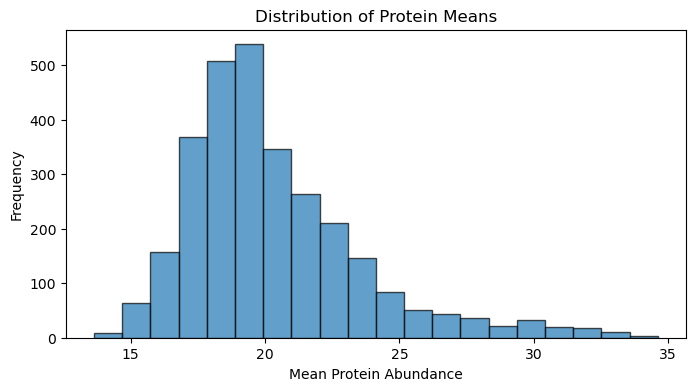

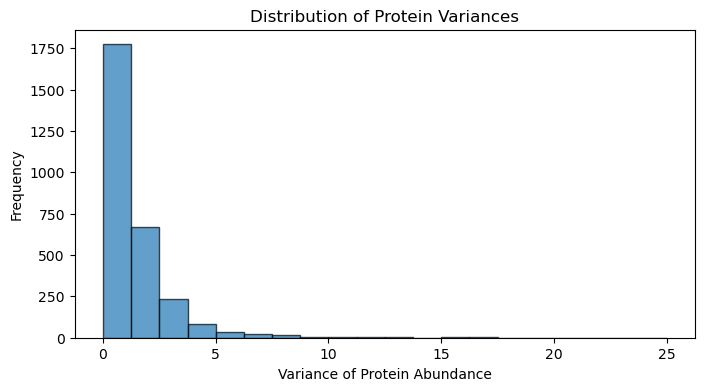

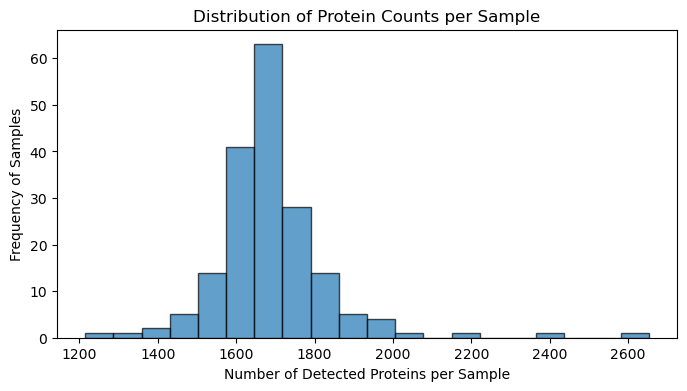

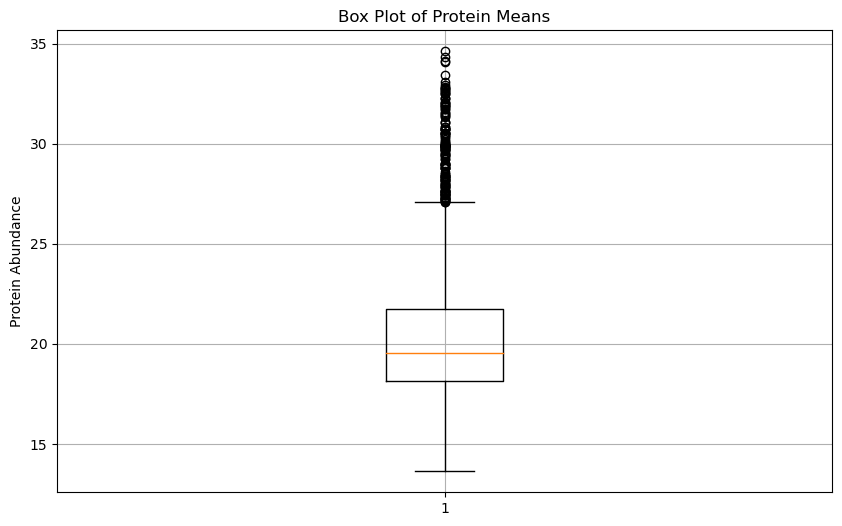

In [13]:
df_view = describe_proteins_and_samples(df_rename)

Shape after dropping immune proteins: (182, 2906)
Shape after dropping keratin: (182, 2819)
Shape after filtering low prevalence proteins: (182, 1601)
Proteins with variance above threshold (threshold=0.05): (182, 1585)


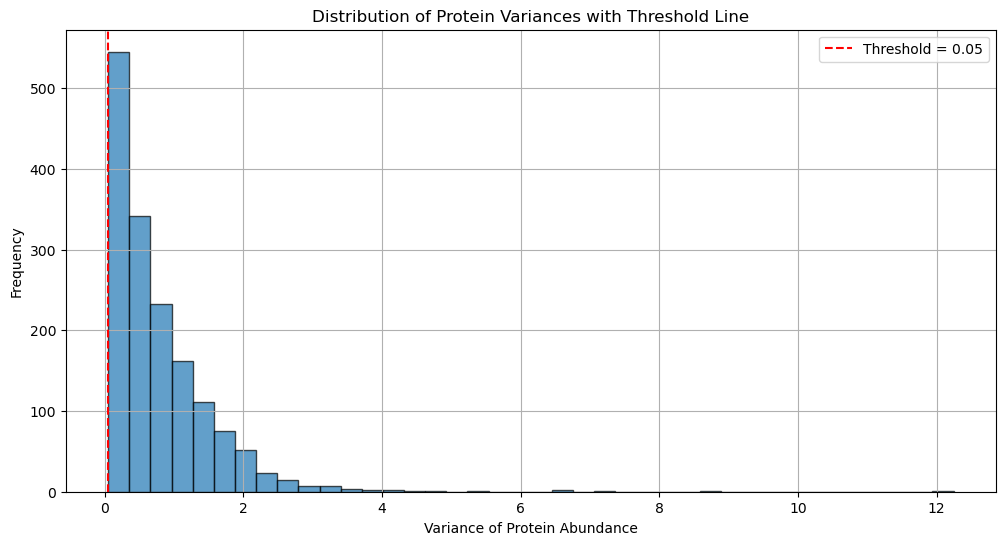

In [14]:
df_drop = drop_protein(df_rename, threshold= 0.05)
#data_for_cox = fill_NA(df_rename)
#data_for_cox

In [15]:
final_df = norm_and_log(df_drop)

Sum of rows is 1: True
Sum of the first 3 rows after normalization:sample number
705    1.0
712    1.0
717    1.0
dtype: float64


In [18]:
final_df

,IGKV3-7,IGLV4-69,IGLV8-61,IGLV10-54,IGLV7-46,IGLV2-18,IGLV3-12,IGLV3-10,IGLV3-9,IGHV3-64,...,FHOD1,F11R,CPQ,EMILIN1,ROBO1,FCGBP,PCLO,COLEC10,APOA2_1,C1QA_1
sample number,,,,,,,,,,,,,,,,,,,,,
705,-10.204612,-10.677011,-10.371133,NaN,-10.386636,-10.708409,-10.775475,-10.387228,-10.398862,-10.477047,...,NaN,-10.670093,-10.439961,-10.899460,-10.745309,-10.248069,-10.350124,-10.367277,-10.838142,-10.920926
712,-10.261845,-10.631851,-10.553399,-11.033184,-10.423710,-10.553404,-10.781720,-10.423317,-10.412205,-10.730202,...,-10.850277,-10.657312,-10.422698,-10.950635,NaN,-10.267445,-10.381524,-10.393928,-10.631400,-10.930997
717,-10.181705,-10.596433,-10.329450,-10.801589,-10.347386,-10.586745,-10.618414,-10.385198,-10.328863,-10.465309,...,NaN,-10.709023,-10.448542,-10.910915,-10.743102,-10.216805,-10.298914,-10.361038,-10.591157,-10.895410
735,-10.201382,-10.620339,-10.525987,-10.974413,-10.394055,-10.628799,-10.773907,-10.424033,-10.409433,-10.614421,...,NaN,-10.686301,-10.396404,-10.994565,-10.704648,-10.234386,-10.388122,-10.370060,-10.699101,-10.765072
746,-10.315008,-10.890091,-10.478634,NaN,-10.518827,-10.726851,NaN,-10.535779,-10.430381,-10.614006,...,NaN,-10.662715,-10.436940,-10.940494,NaN,-10.255990,-10.448063,-10.373641,-10.813603,-10.790747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,-10.213779,-10.589771,NaN,-10.901073,-10.311487,-10.580031,-10.571975,-10.385638,-10.289457,-10.474354,...,NaN,-10.616867,-10.428219,NaN,-10.587708,-10.184392,-10.402729,-10.316921,NaN,-10.476288
1900,-10.154755,-10.651093,-10.311946,NaN,-10.368999,-10.833229,NaN,-10.562737,-10.423335,-10.521348,...,-10.845889,-10.566973,-10.405265,-10.918730,NaN,-10.219864,-10.382083,-10.324470,-10.680722,-10.440002
1912,-10.114605,-10.549059,-10.556772,-10.874781,-10.491286,-10.666894,-10.672145,-10.367900,-10.379130,-10.468953,...,NaN,-10.674030,-10.406008,-10.951507,-10.758552,-10.215317,-10.355471,-10.378270,-10.632625,-10.624632


In [5]:
final_df_cox = norm_and_log(data_for_cox)

final_df_cox
final_df_cox.to_csv('data_fill_nan.csv', index=True)

Sum of rows is 1: True
Sum of the first 3 rows after normalization:705    1.0
712    1.0
717    1.0
dtype: float64


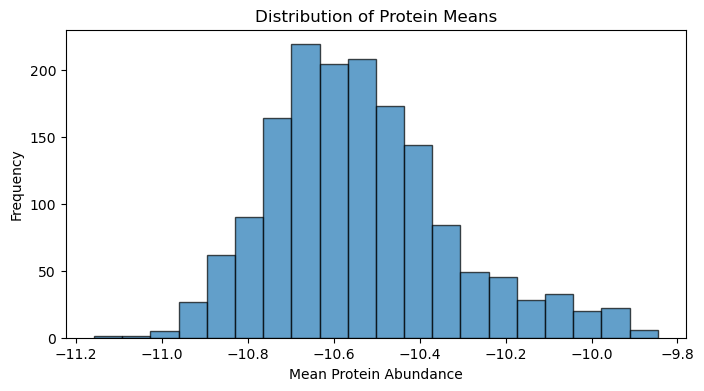

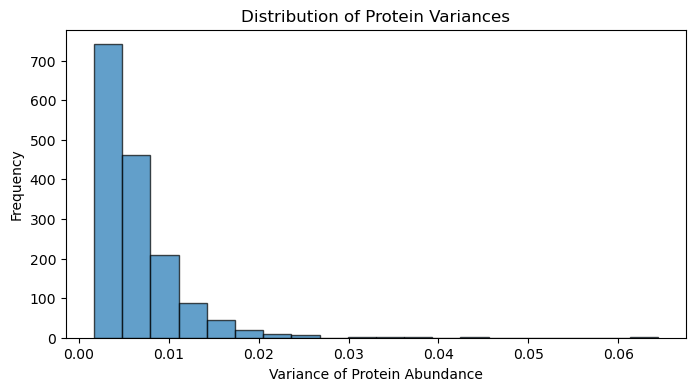

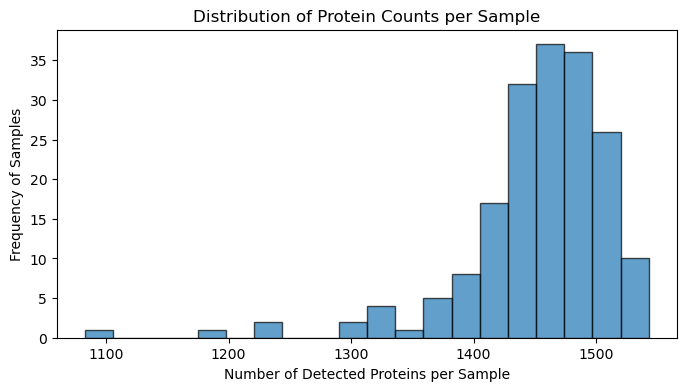

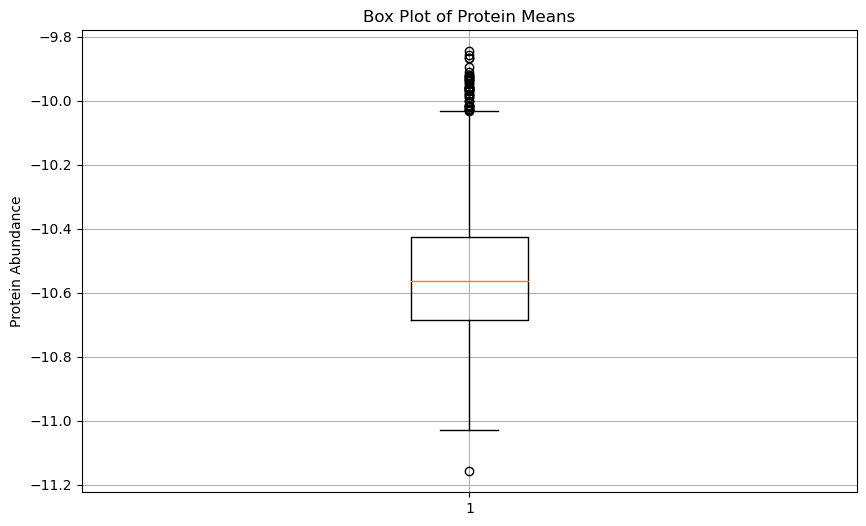

In [17]:
df_view = describe_proteins_and_samples(final_df)